In [1]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Scripts
import utils

pd.set_option("display.precision", 10)
pd.set_option("display.max_columns", 500)

%matplotlib inline

In [2]:
DATA_PATH = "data/test"
MODEL_PATH = "models/" + DATA_PATH.split("/")[-1]

In [3]:
df = pd.read_csv(f"{DATA_PATH}/data_reduced_noisy.csv", index_col=0)
df

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Power
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0000472315
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0000453972
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0000473517
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0000453586
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0000454614
...,...,...,...,...,...,...,...,...
1123195,1123195,2021-01-13 23:59:55,0.0,0.0,0.0,0.0,0.0,0.0000245179
1123196,1123196,2021-01-13 23:59:56,0.0,0.0,0.0,0.0,0.0,0.0000254437
1123197,1123197,2021-01-13 23:59:57,0.0,0.0,0.0,0.0,0.0,0.0000250264
1123198,1123198,2021-01-13 23:59:58,0.0,0.0,0.0,0.0,0.0,0.0000237630


## Create windowed data if necessary

In [4]:
window_size = 180
step = 1
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]
windowed_data_path = f"{DATA_PATH}/windowed_{window_size}_step_{step}_noisy.csv"

In [5]:
df_timeseries = utils.write_or_load_windows(
    windowed_data_path, df, window_size, step, appliances
)
df_timeseries

Window file not found, creating a new one for window size 180 and step size 1
Step 0 with array size 1123200
Step 10000 with array size 1123200
Step 20000 with array size 1123200
Step 30000 with array size 1123200
Step 40000 with array size 1123200
Step 50000 with array size 1123200
Step 60000 with array size 1123200
Step 70000 with array size 1123200
Step 80000 with array size 1123200
Step 90000 with array size 1123200
Step 100000 with array size 1123200
Step 110000 with array size 1123200
Step 120000 with array size 1123200
Step 130000 with array size 1123200
Step 140000 with array size 1123200
Step 150000 with array size 1123200
Step 160000 with array size 1123200
Step 170000 with array size 1123200
Step 180000 with array size 1123200
Step 190000 with array size 1123200
Step 200000 with array size 1123200
Step 210000 with array size 1123200
Step 220000 with array size 1123200
Step 230000 with array size 1123200
Step 240000 with array size 1123200
Step 250000 with array size 1123200


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68,sample_69,sample_70,sample_71,sample_72,sample_73,sample_74,sample_75,sample_76,sample_77,sample_78,sample_79,sample_80,sample_81,sample_82,sample_83,sample_84,sample_85,sample_86,sample_87,sample_88,sample_89,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,sample_100,sample_101,sample_102,sample_103,sample_104,sample_105,sample_106,sample_107,sample_108,sample_109,sample_110,sample_111,sample_112,sample_113,sample_114,sample_115,sample_116,sample_117,sample_118,sample_119,sample_120,sample_121,sample_122,sample_123,sample_124,sample_125,sample_126,sample_127,sample_128,sample_129,sample_130,sample_131,sample_132,sample_133,sample_134,sample_135,sample_136,sample_137,sample_138,sample_139,sample_140,sample_141,sample_142,sample_143,sample_144,sample_145,sample_146,sample_147,sample_148,sample_149,sample_150,sample_151,sample_152,sample_153,sample_154,sample_155,sample_156,sample_157,sample_158,sample_159,sample_160,sample_161,sample_162,sample_163,sample_164,sample_165,sample_166,sample_167,sample_168,sample_169,sample_170,sample_171,sample_172,sample_173,sample_174,sample_175,sample_176,sample_177,sample_178,sample_179,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.0000472315,0.0000453972,0.0000473517,0.0000453586,0.0000454614,0.0000485080,0.0000479577,0.0000466298,0.0000473019,0.0000462348,0.0000465549,0.0000472695,0.0000453912,0.0000444484,0.0000453770,0.0000469510,0.0000457064,0.0000442620,0.0000434221,0.0000453886,0.0000451688,0.0000461576,0.0000419241,0.0000466182,0.0000467132,0.0000470272,0.0000450980,0.0000466102,0.0000459478,0.0000465695,0.0000459636,0.0000483252,0.0000441156,0.0000482241,0.0000451017,0.0000459436,0.0000434255,0.0000457474,0.0000435522,0.0000490150,0.0000474629,0.0000477814,0.0000442273,0.0000454035,0.0000436886,0.0000461738,0.0000481037,0.0000469560,0.0000460556,0.0000462457,0.0000435077,0.0000445934,0.0000446956,0.0000463042,0.0000475777,0.0000463528,0.0000471909,0.0000462264,0.0000455520,0.0000448661,0.0000468034,0.0000458701,0.0000445694,0.0000469979,0.0000432209,0.0000482912,0.0000463374,0.0000453449,0.0000466315,0.0000442781,0.0000450167,0.0000429562,0.0000448146,0.0000468605,0.0000453047,0.0000438172,0.0000464089,0.0000459434,0.0000465274,0.0000443679,0.0000472340,0.0000464945,0.0000447559,0.0000437363,0.0000456426,0.0000445840,0.0000445946,0.0000440609,0.0000470115,0.0000455820,0.0000449558,0.0000449073,0.0000441543,0.0000461654,0.0000458211,0.0000494487,0.0000450399,0.0000445947,0.0000456650,0.0000431215,0.0000442750,0.0000461750,0.0000425729,0.0000452951,0.0000450709,0.0000446376,0.0000434769,0.0000448001,0.0000448393,0.0000482766,0.0000462690,0.0000441186,0.0000461784,0.0000468750,0.0000454535,0.0000444246,0.0000470653,0.0000461288,0.0000463221,0.0000447024,0.0000444742,0.0000487407,0.0000484079,0.0000438742,0.0000439122,0.0000448091,0.0000432842,0.0000446974,0.0000431918,0.0000453788,0.0000473219,0.0000458088,0.0000477468,0.0000473041,0.0000462693,0.0000466196,0.0000452857,0.0000432897,0.0000460988,0.0000457752,0.0000468975,0.0000458260,0.0000443071,0.0000472455,0.0000459345,0.0000431515,0.0000461371,0.0000440717,0.0000436482,0.0000460972,0.0000451807,0.0000450294,0.0000458146,0.0000467235,0.0000463998,0.0000432572,0.0000454987,0.0000441871,0.0000459084,0.

## Train test split (has to be identical to training for noisy dataset)

In [6]:
samples = [x for i, x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True
)

In [9]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

## Load model under test

In [10]:
MODEL_NAME = "DLO_128,128,128,256,512_90er_kernel_GlobalMaxPool_model"
LR = 6e-07
EPOCHS = 100
BATCH_SIZE = 256

In [11]:
model = tf.keras.models.load_model(
    f"{MODEL_PATH}/{MODEL_NAME}/LR={LR},Epochs={EPOCHS},BATCH={BATCH_SIZE}"
)

In [12]:
# the exact configuration of the model
# model.get_config()
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 1)]          0         
                                                                 
 conv1d_80 (Conv1D)          (None, 180, 128)          11648     
                                                                 
 re_lu_97 (ReLU)             (None, 180, 128)          0         
                                                                 
 batch_normalization_97 (Bat  (None, 180, 128)         512       
 chNormalization)                                                
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 90, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_81 (Conv1D)          (None, 90, 128)           147

In [13]:
THRESHOLD = 0.5
y_pred = model.predict(X_test)
y_pred[y_pred >= THRESHOLD] = 1
y_pred[y_pred < THRESHOLD] = 0
y_pred

array([[1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [14]:
test_loss, test_auc, test_acc = model.evaluate(X_test, y_test)

print("Test AUC", test_auc)
print("Test Acc", test_acc)
print("Test loss", test_loss)

7019/7019 [==============================] - 67s 9ms/step - loss: 1.2359 - auc: 0.6861 - binary_accuracy: 0.7255
Test AUC 0.6861161589622498
Test Acc 0.7255166172981262
Test loss 1.2359024286270142


In [15]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred)

print(
    classification_report(y_test, y_pred, target_names=appliances, zero_division=False)
)

                 precision    recall  f1-score   support

          Stove       0.14      0.88      0.25     18671
 Coffee_machine       0.22      0.05      0.08      3185
      Microwave       0.19      0.78      0.31      3753
     Dishwasher       0.20      0.29      0.23     25534
Washing_machine       0.04      0.64      0.08      9248

      micro avg       0.10      0.54      0.18     60391
      macro avg       0.16      0.53      0.19     60391
   weighted avg       0.16      0.54      0.21     60391
    samples avg       0.08      0.12      0.10     60391



Accuracy: 0.5519378464415307


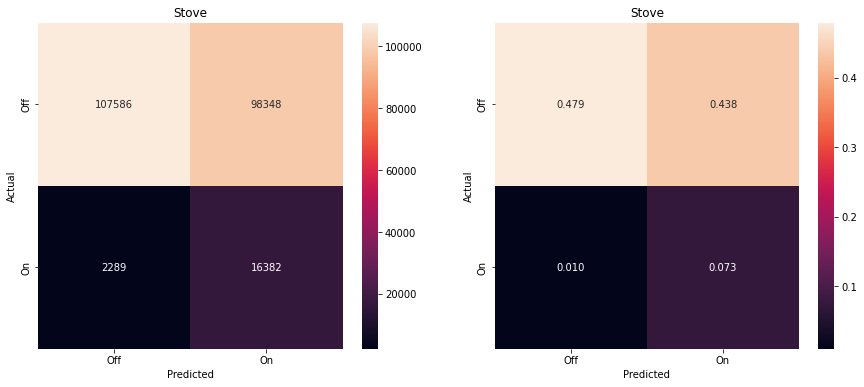

Accuracy: 0.9840341933616794


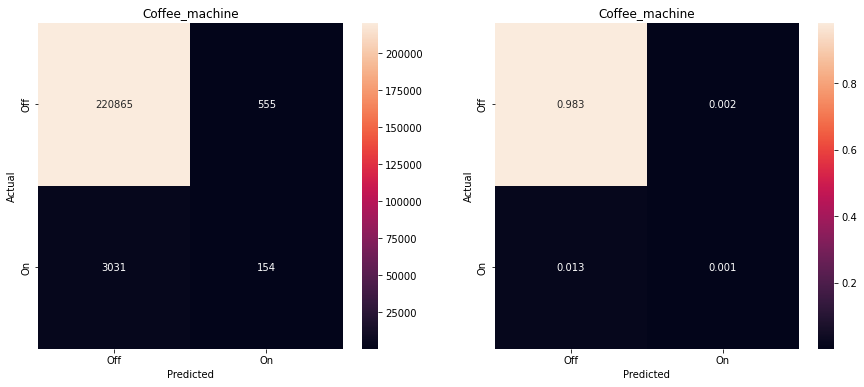

Accuracy: 0.9404599185236304


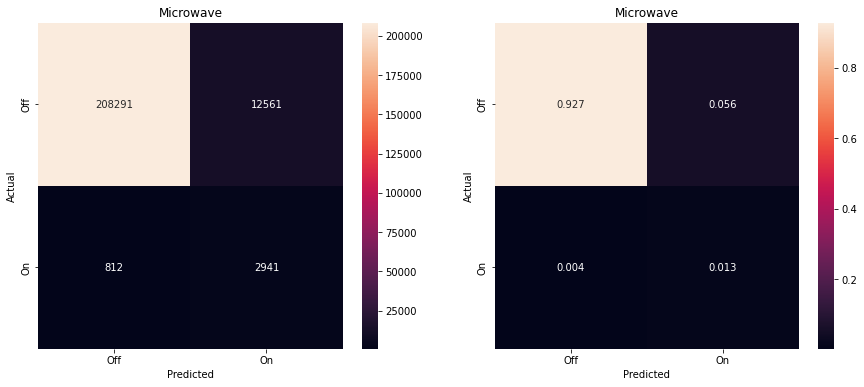

Accuracy: 0.7876984038645622


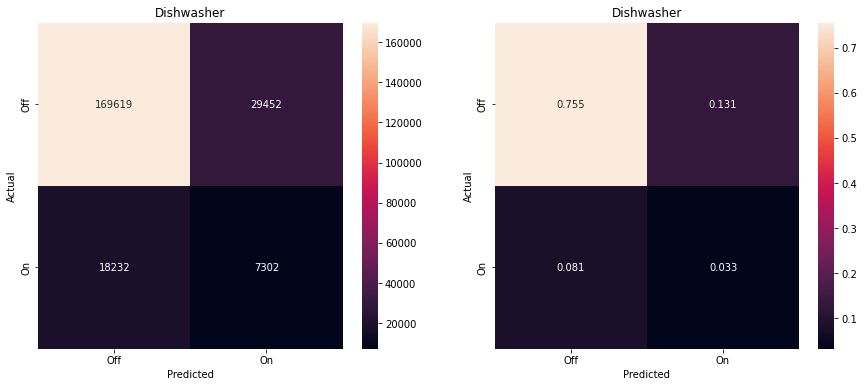

Accuracy: 0.3634513924445137


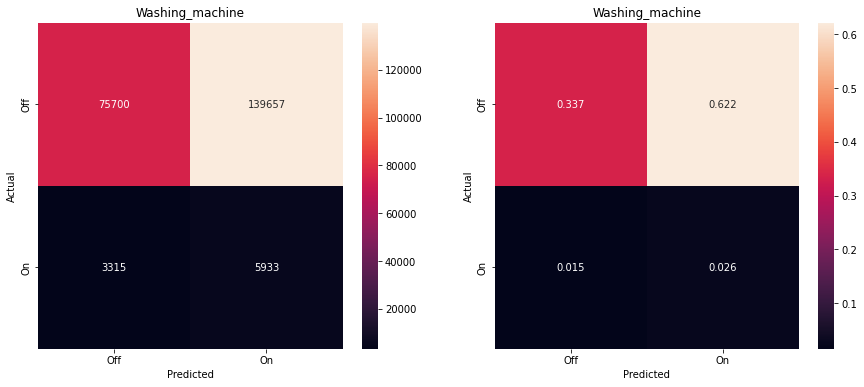

In [16]:
columns = ["Off", "On"]
for idx, item in enumerate(mcm):
    tn, fp, fn, tp = item.ravel()
    print(f"Accuracy: {(tp+tn)/(tn+fp+fn+tp)}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    heat = sns.heatmap(
        item, annot=True, fmt="1", xticklabels=columns, yticklabels=columns, ax=ax1
    )
    norm_item = item.astype("float") / item.sum(axis=None)
    norm_heat = sns.heatmap(
        norm_item,
        annot=True,
        fmt=".3f",
        xticklabels=columns,
        yticklabels=columns,
        ax=ax2,
    )
    for ax in [ax1, ax2]:
        ax.set_title(appliances[idx])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()